In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO
import numpy as np
from PIL import Image, ImageColor, ImageDraw, ImageFont, ImageOps
import time
import os
import random

In [2]:
random_images = 'rose'

In [3]:
def display_image(image,file):
    fig = plt.figure(figsize=(9, 6))
    plt.grid(False)
    plt.imshow(image)
    plt.title(file, fontsize=20)
def resize_image(img, new_width=150, new_height=150,display=False):
    img_path = os.path.join(random_images,img)
    pil_image = Image.open(img_path)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
    pil_image_rgb = pil_image.convert("RGB")
    if display:
        display_image(pil_image, img)

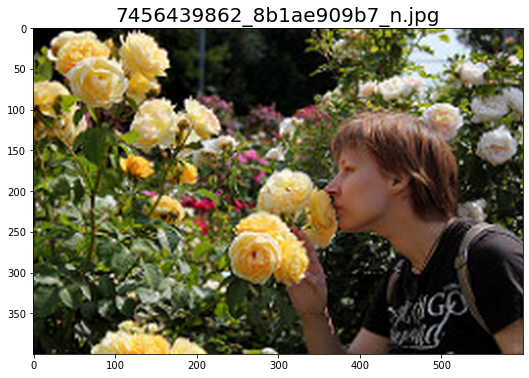

In [4]:
resize_image(random.choice(os.listdir(random_images)),600,400,True)

In [5]:
def draw_bounding_box_on_image(image,ymin,xmin,ymax,xmax,color,font,thickness=4,display_str_list=()):
       
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),(left, top)],width=thickness,fill=color)
    
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)
    
    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height
        
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),(left + text_width, text_bottom)],fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),display_str, fill="black", font=font)
        text_bottom -= text_height - 2 * margin
        

def draw_boxes(image, boxes, class_names, scores, max_boxes=3, min_score=0.1):
    
    colors = list(ImageColor.colormap.values())
    font = ImageFont.load_default()
    
    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            
            draw_bounding_box_on_image(image_pil,ymin,xmin,ymax,xmax,color,font,display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    return image

In [6]:
model_path = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
PreTrained_Model = hub.load(model_path).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [7]:
def load_img(img_file):
    path = os.path.join(random_images,img_file)
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

In [8]:
def detect(model, img_file):
    img = load_img(img_file)
    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    start_time = time.time()
    result = model(converted_img)
    end_time = time.time()
    result = {key:value.numpy() for key,value in result.items()}
    print("Found %d objects." % len(result["detection_scores"]))
    print("Inference time (secs): ",'{:.2}'.format(end_time-start_time))
    image_with_boxes = draw_boxes(img.numpy(), result["detection_boxes"],result["detection_class_entities"], result["detection_scores"])
    display_image(image_with_boxes,img_file)

Found 100 objects.
Inference time (secs):  1.7e+01


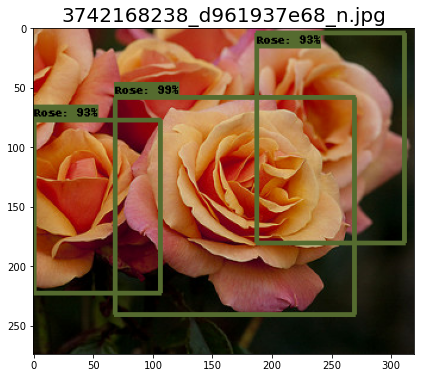

In [13]:
detect(PreTrained_Model, random.choice(os.listdir(random_images)))